In [1]:
from skxray.core.correlation import lazy_one_time
import numpy as np
import time as ttime
import matplotlib.pyplot as plt
%matplotlib notebook

## First, let's demo with synthetic data.

The plot a few cells down should live update with the first value of approximately sqrt(2) and the remaining values should be essentially one

In [2]:
num_levels = 5
num_bufs = 4  # must be even
xdim = 512
ydim = 512
stack_size = 100
synthetic_data = np.random.randint(1, 10, (stack_size, xdim, ydim))

rois = np.zeros_like(synthetic_data[0])
# make sure that the ROIs can be any integers greater than 1. They do not
# have to start at 1 and be continuous
rois[0:xdim//10, 0:ydim//10] = 5
rois[xdim//10:xdim//5, ydim//10:ydim//5] = 3

### Define a helper function to process and update the live plot

In [3]:
def update_plot(ax, g2s, lags, img_num):
    ax.cla()
    for n, g2 in enumerate(g2s.T):
        ax.plot(lags[:len(g2)], g2, '-o', label='roi%s' % n)
    ax.set_title('processed %s images' % img_num)
    ax.legend(loc=0)
    ax.set_xlabel('Log time (s)')
    ax.set_ylabel('Correlation')
    try:
        ax.set_xscale('log')
        ax.figure.canvas.draw()
    except ValueError:
        # this happens on the first few draws
        ax.set_xscale('linear')
        ax.figure.canvas.draw()
    ttime.sleep(0.001)

## Show the correlator working with synthetic data

<IPython.core.display.Javascript object>


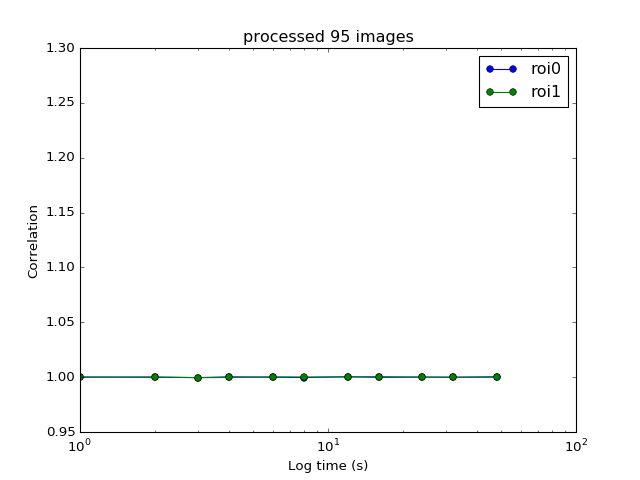

In [4]:
fig, ax = plt.subplots()


In [5]:
corr_gen = lazy_one_time(synthetic_data, num_levels, num_bufs, rois)
for counter, res in enumerate(corr_gen):
    # only update the plot every 5th image processed.
    if counter % 5 == 0:
        update_plot(ax, res.g2, res.lag_steps, counter)

## Now let's do it with some real data

In [6]:
from skxray.core import roi
from xray_vision.mpl_plotting import show_label_array

In [7]:
# multi-tau scheme info
real_data_levels = 7
real_data_bufs = 8
real_data = np.load("100_500_NIPA_GEL.npy")

# generate some circular ROIs
# define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), real_data.shape[1:])

### Plot the ROIs over the averaged image

<IPython.core.display.Javascript object>


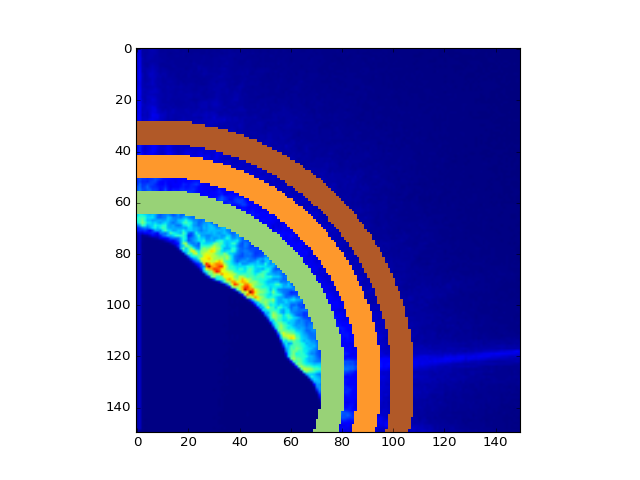

In [9]:
fig, ax = plt.subplots()
ax.imshow(np.sum(real_data, axis=0) / len(real_data))
show_label_array(ax, labeled_roi_array)

### Use the class-based partial data correlator in scikit-beam

<IPython.core.display.Javascript object>


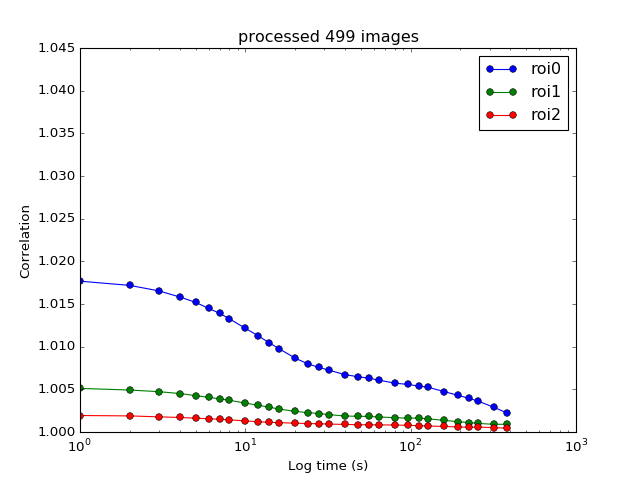

In [12]:
fig2, ax2 = plt.subplots()
ax2.set_xscale('log')

#### Show incremental updates with the generator implementation of the correlator

In [13]:
gen = lazy_one_time(real_data, real_data_levels, real_data_bufs, labeled_roi_array)
for counter, result in enumerate(gen):
    # update image every 10th image for performance
    if counter % 10 == 0:
        update_plot(ax2, result.g2, result.lag_steps, counter)
else:
    # do a final update to get the last bit
    update_plot(ax2, result.g2, result.lag_steps, counter)

### `multi_tau_auto_corr` used to be the reference implementation.  It now wraps the generator implementation

In [14]:
from skxray.core.correlation import multi_tau_auto_corr

In [15]:
%%timeit -n5
pass
gen = lazy_one_time(real_data, real_data_levels, real_data_bufs, labeled_roi_array)
results = list(gen)[-1]
results.g2, results.lag_steps

5 loops, best of 3: 439 ms per loop


In [16]:
%%timeit -n5
pass
g2, lags = multi_tau_auto_corr(
    real_data_levels, real_data_bufs, labeled_roi_array, (im for im in real_data))

5 loops, best of 3: 445 ms per loop


### Demonstrate that the two implementations produce the same result

In [17]:
gen = lazy_one_time(real_data, real_data_levels, real_data_bufs, labeled_roi_array)
results = list(gen)

g2, lags = multi_tau_auto_corr(
    real_data_levels, real_data_bufs, labeled_roi_array, (im for im in real_data))

assert np.all(results[-1].g2 == g2)